In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Utils import *
from Evaluation import *
from Read_Platelayouts import load_layout
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd

# Hefekulturen

To generate a broad understanding of the p-value and its meaning in statistics, please read: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5665734/

## 1. Define Files to Evaluate

Please edit the path to the reference plate (`path_to_reference_plate`) and experiment plate (`path_to_experiment_plate`) as well as the folder to save the results to (`save_results_folder`)

**Attention** Please make sure that the images are cropped, in such way that only the yeast colonies are visible.

In [3]:
path_to_reference_plate = r"/home/hansel/Data/Hefekulturen/Data_May_2023/Spa2/C_Gen_D3.JPG" #r"./Data\36_MPA_ref_d3.JPG" # 
path_to_experiment_plate = r"/home/hansel/Data/Hefekulturen/Data_May_2023/Spa2/C_Cu50_D3.JPG" #r"./Data\36_MPA_Cu0_d3.JPG"  #

save_results_folder = r"./Results_May2023/Spa2/"

`MIN_COLONY_SIZE` is used to exclude colonies that did not grow. The value is defined by the smallest 3% of all colonies computed over a set of experiment and reference plates. The value was set based on experience. Please only change if you know what you are doing. 



In [4]:
MIN_COLONY_SIZE = 85.0 # this is approximated by the smallest 3% in all plates 

`P_VALUE_NULLHYPOTHESIS` is the considered p-value of the statistical tests used for finding significant differences between row A and B. Please only change if you know what you are doing. 

In [5]:
P_VALUE_NULLHYPOTHESIS = 0.01

**Exp1: Absolut Growth**

*Evaluate growth of row A and B compared to other colonies on plate.*

If `PERCENTILE` is set to -1 (use as default), use outlier detection based on IQR (Interquantilerange) to find colonies that have grown significantly more than other colonies on plate.

However, `PERCENTILE` can be adapted to detect values above certain percentile. To define the percentile set the variable to a value between 1 - 100

In [6]:
PERCENTILE = -1 # only change when you know what you are doing.

Please only set `USE_HARD_GRID` to `True` if the grid (Section *2.2. Compute Colony Sizes*) is not working properly.

WARNING:: This can lead to small inaccuracies at colony borders.

In [7]:
USE_HARD_GRID = False

In [8]:
if("A_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 32 
    layout_names = load_layout('Plate_Layouts/MPA.csv')
    # TODO load names
elif("B_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 32 
    layout_names = load_layout('Plate_Layouts/MPB.csv')
elif("C_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 28 
    layout_names = load_layout('Plate_Layouts/MPCD.csv')


In [9]:
os.makedirs(save_results_folder, exist_ok=True)

## 2. Open and Preprocess Images

### 2.1. Open Images as Binary

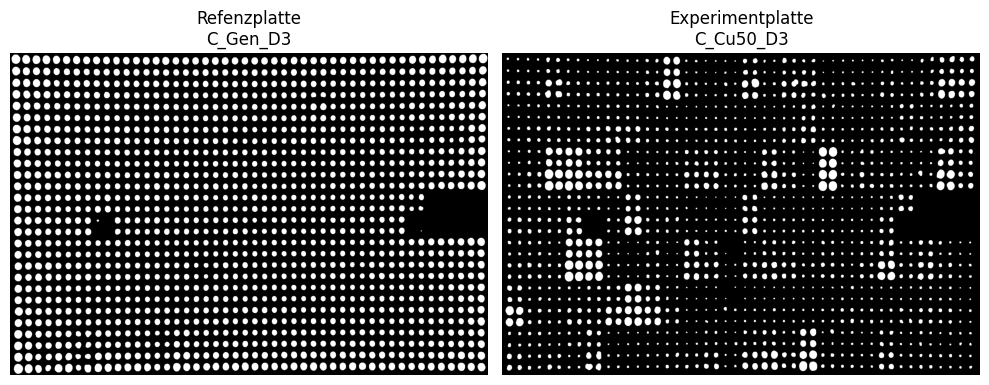

In [10]:
reference_plate = open_image(path_to_reference_plate)
experiment_plate = open_image(path_to_experiment_plate)

fig, axs = plt.subplots(1,2, figsize = (10,10*2))
axs[0].imshow(reference_plate, cmap="gray")
axs[1].imshow(experiment_plate, cmap="gray")
axs[0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
axs[1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.tight_layout()
plt.show()

### 2.2. Compute Colony Sizes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


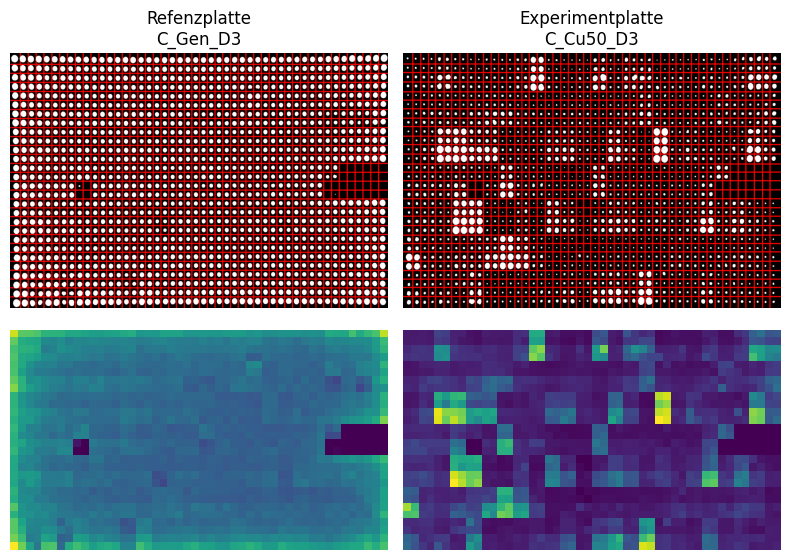

In [11]:
rgb_grid_reference, sizes_reference, x_start, x_end, y_start, y_end = compute_grid(reference_plate, x_expected, y_expected, USE_HARD_GRID, plot = False)
rgb_grid_experiment, sizes_experiment, x_start, x_end, y_start, y_end = compute_grid(experiment_plate, x_expected, y_expected, USE_HARD_GRID, plot = False)

if((not np.any(rgb_grid_reference == None)) and (not np.any(rgb_grid_experiment == None))):
    fig, axs = plt.subplots(2,2, figsize = (4*2,4*1.5))
    axs[0,0].imshow(rgb_grid_reference)
    axs[0,1].imshow(rgb_grid_experiment)
    axs[0,0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
    axs[0,1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
    axs[0,0].set_axis_off()
    axs[0,1].set_axis_off()

    axs[1,0].imshow(sizes_reference) #, cmap= "plasma")
    axs[1,1].imshow(sizes_experiment) #, cmap= "plasma")
    axs[1,0].set_axis_off()
    axs[1,1].set_axis_off()
    plt.tight_layout()
    plt.autoscale(False)
    plt.show()



## 3. Evaluate
- Normalize experimental plate in relation to reference plate
- Find invalid quadruples (Exclude inaccuracies on reference plate and missing values)
- Exp1: Find quadruple where either all colonies of the row A quadruple or all colonies of the row B quadruple are outliers compared to other colonies
- Exp2: Find siginificant differences between row A and row B
- Saves .pdf into results folder with images

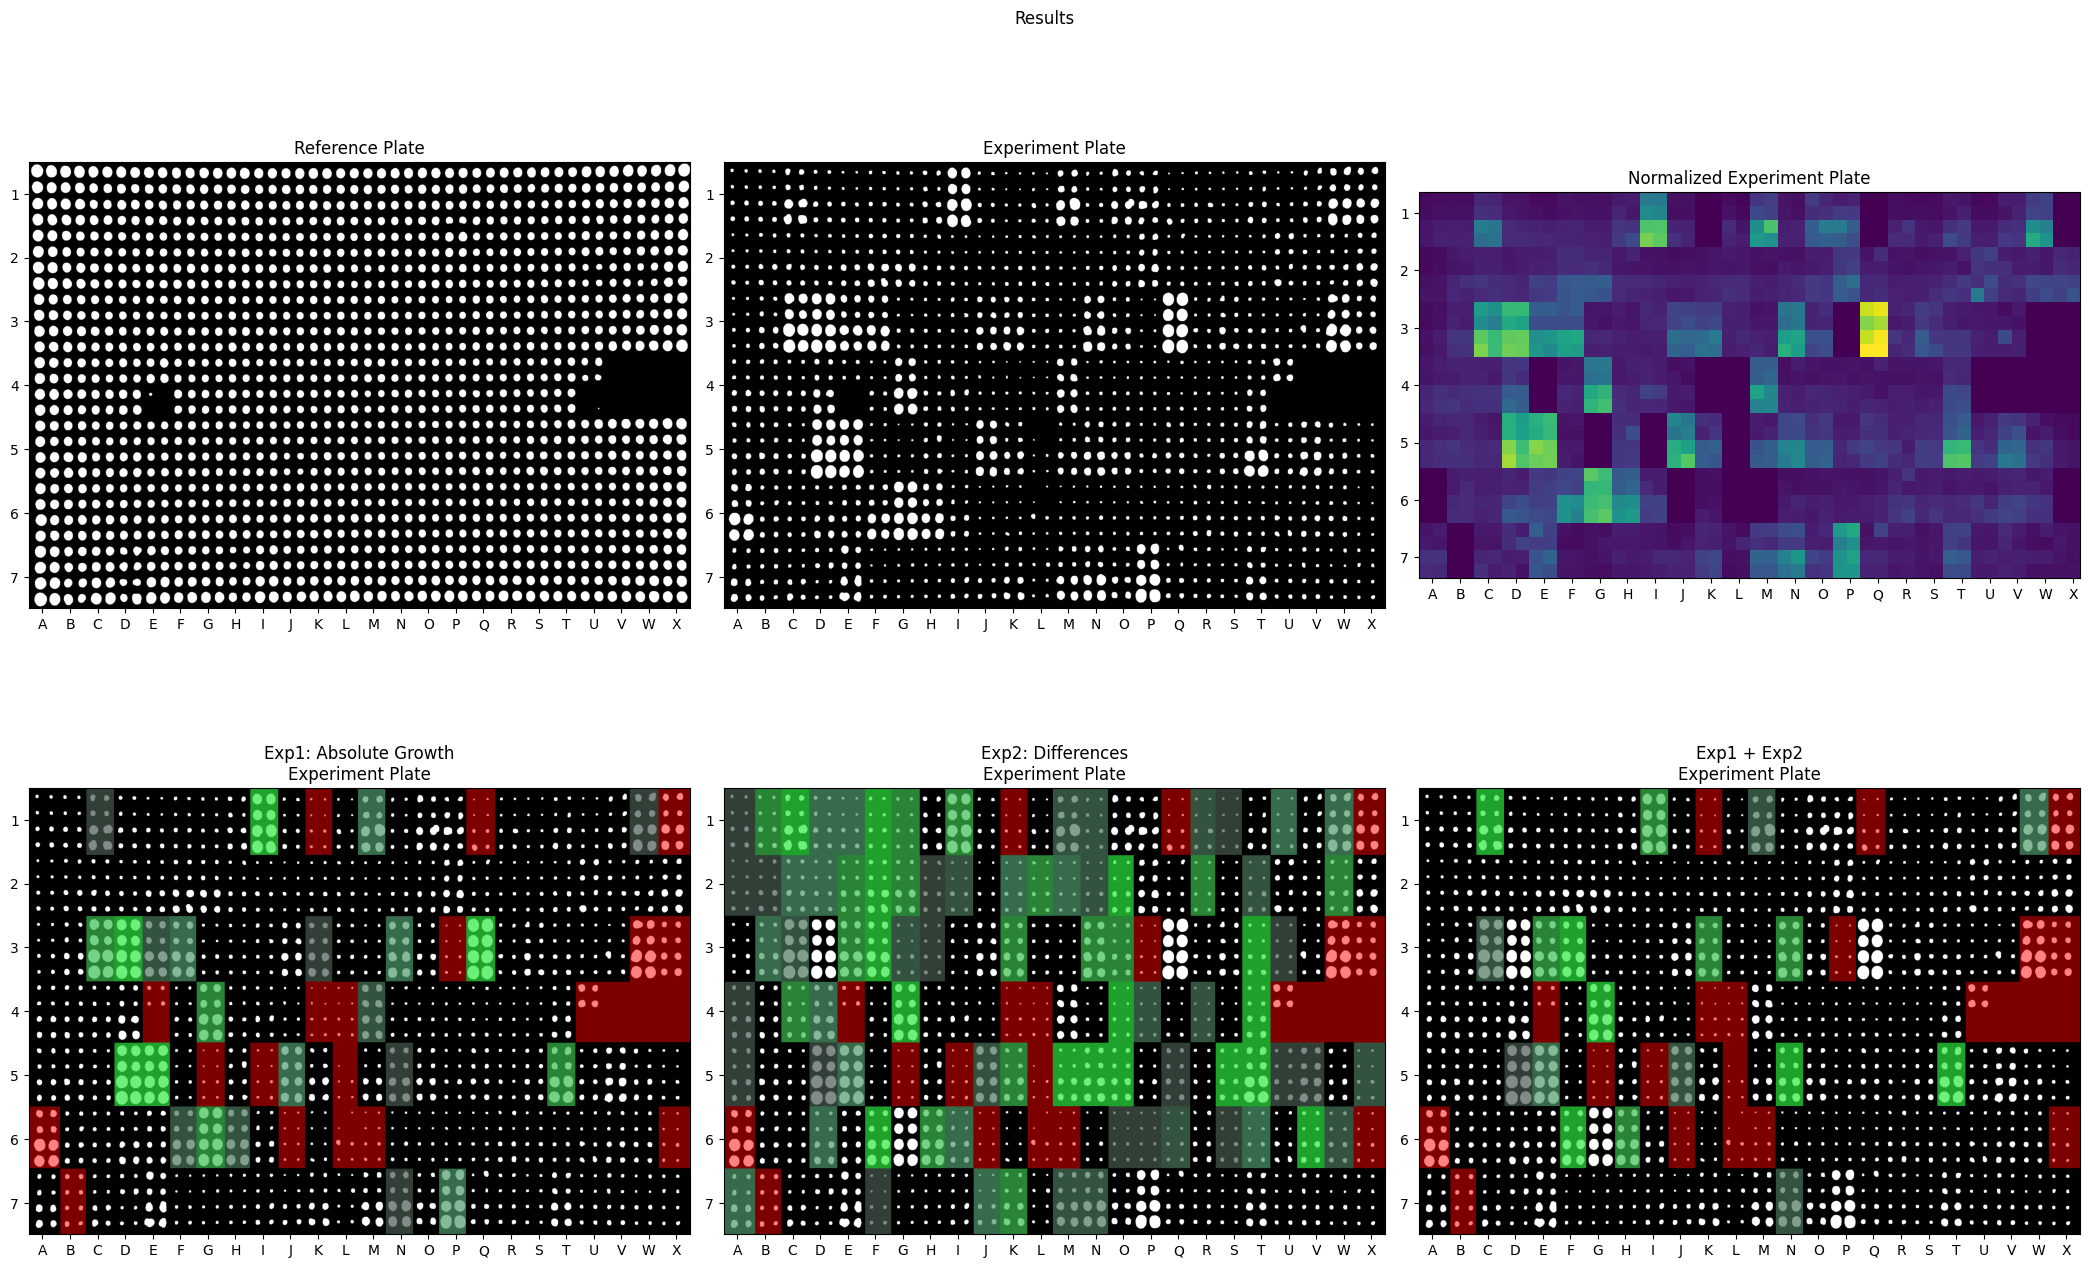

In [12]:
quadruples, minimum_size = evaluate(experiment_plate, 
                      reference_plate, 
                      sizes_experiment, 
                      sizes_reference, 
                      x_start, 
                      x_end, 
                      y_start, 
                      y_end, 
                      layout_names,
                      MIN_COLONY_SIZE, 
                      P_VALUE_NULLHYPOTHESIS, 
                      PERCENTILE, 
                      log_dir = save_results_folder+"Result_"+str(Path(path_to_experiment_plate).stem)+".pdf")

## 4. Save Data to Excel Sheet

In [15]:
data = {'Position': [quad.position[1]+" "+quad.position[0] for quad in quadruples], 
        'Name': [str(quad.name) for quad in quadruples], 
        'Exp1: Absolut Size': [quad.absolute_size for quad in quadruples],
        'Exp1: Absolut Size Minimum Threshold': [minimum_size for quad in quadruples],

        'Exp2: P-Value': [quad.p_value for quad in quadruples], 
        'Exp2: Effect Size': [quad.effect_size for quad in quadruples], 
        
        'Is Valid' : [quad.is_valid for quad in quadruples], 
        'Reason': [quad.reason for quad in quadruples],

        'Bigger Row': [quad.bigger_row for quad in quadruples],

        'A1 Normalized': [str(quad.quadrupelA.sizes[0]) for quad in quadruples], 
        'A2 Normalized': [str(quad.quadrupelA.sizes[1]) for quad in quadruples], 
        'A3 Normalized': [str(quad.quadrupelA.sizes[2]) for quad in quadruples], 
        'A4 Normalized': [str(quad.quadrupelA.sizes[3]) for quad in quadruples], 

        'B1 Normalized': [str(quad.quadrupelA.sizes[0]) for quad in quadruples], 
        'B2 Normalized': [str(quad.quadrupelA.sizes[1]) for quad in quadruples], 
        'B3 Normalized': [str(quad.quadrupelA.sizes[2]) for quad in quadruples], 
        'B4 Normalized': [str(quad.quadrupelA.sizes[3]) for quad in quadruples], 

        'A Mean' : [np.mean(quad.quadrupelA.sizes) for quad in quadruples], 
        'B Mean' : [np.mean(quad.quadrupelB.sizes) for quad in quadruples], 

        'ordinal scale': [quad.ordinal_scale for quad in quadruples]}
df = pd.DataFrame(data=data)    

df = df.sort_values(by=['ordinal scale'], ascending=False)
df = df.sort_values(by=['ordinal scale'], ascending=False)

df.to_excel(save_results_folder+"/Result_"+str(Path(path_to_experiment_plate).stem)+".xlsx")

print(f"INFO::Evaluation done. Results can be found here: {os.path.abspath(save_results_folder)}")

INFO::Evaluation done. Results can be found here: /media/hansel/SSD/Code/Hefekulturen/Results_May2023/Spa2
